In [1]:
#Importing library

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import datetime

from scipy import stats
from scipy.stats import skew
from scipy.stats import norm
from scipy.stats.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from math import sqrt
from sklearn.feature_selection import SelectFromModel

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

define the error function

In [2]:
def errore(ypred, y, val):
    val=val.reset_index(drop=True)
    y = y.reset_index(drop=True)

    columns=['Date', 'StoreID', 'RegionID', 'SalesPredicted', 'SalesReal']
    index=range(y.shape[0])
    result=pd.DataFrame(index=index,columns=columns)

    result['Date']=val['Date']
    result['StoreID']=val['StoreID']
    result['RegionID']=val['Region']
    result['SalesPredicted']=ypred
    result['SalesReal']=y
    

    # Transform dates from '%Y-%m-%d' to datetime objects.
    def transform_date(x):
        date = datetime.datetime.strptime(x, '%Y-%m-%d')
        return date

    result['Date'] = result['Date'].map(transform_date)
    result['Month'] = result.Date.map(lambda d: d.strftime('%Y-%m'))
    result = result.groupby(['StoreID', 'RegionID', 'Month']).sum().reset_index()[['Month', 'StoreID', 'RegionID', 'SalesPredicted', 'SalesReal']]

    result['SalesError'] = abs(result.SalesPredicted - result.SalesReal)

    region_error = (result.groupby('RegionID').sum().SalesError / result.groupby('RegionID').sum().SalesReal).reset_index().rename(columns={0: 'RegionError'}).set_index('RegionID')
    total_error = np.mean(region_error.RegionError)
    return total_error

Importing dataframe and divide it in training and validation sets

In [4]:
#Importing dataset
df = pd.read_csv("dataset/processed/train_no_val2.csv", index_col=0)
val= df.loc[((df['Date']>='2017-11-01') & (df['Date']<='2017-12-31'))]
train = df.loc[(df['Date']<'2017-11-01')]

check the division is correct

In [5]:
print(df.shape, val.shape, train.shape, val.shape[0] +train.shape[0])

(396575, 49) (30856, 49) (365719, 49) 396575


transform correctly the sets

In [6]:
train.OrdinalDate = train.OrdinalDate.map(lambda x: x % 365)
val.OrdinalDate = val.OrdinalDate.map(lambda x: x % 365)
df.OrdinalDate = df.OrdinalDate.map(lambda x: x % 365)

C:\Users\riccardo\Anaconda3\lib\site-packages\pandas\core\generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [7]:
y=train['NumberOfSales']
y_val1=val['NumberOfSales']
y_df=df['NumberOfSales']

In [8]:
X=train.drop(['StoreID','Date', 'NumberOfSales', 'Region'], axis=1)
X_val1=val.drop(['StoreID','Date', 'NumberOfSales', 'Region'], axis=1)
X_df=df.drop(['StoreID','Date', 'NumberOfSales', 'Region'], axis=1)


We run a forest for all the attributes to know the baseline error and calculate the feature importance

In [9]:
nt=100
na=21
depth=40

forest = RandomForestRegressor(max_depth=depth, random_state=0, n_estimators=nt, max_features=na, n_jobs=-1)
forest.fit(X, y)

y_pred = forest.predict(X_val1)
mae = mean_absolute_error(y_val1, y_pred)

print(mae)

663.1659614160752


Calculate the features importance and rank it

Feature ranking:
1. feature 41 MeanStoreSales (0.486674)
2. feature 0 HasPromotions (0.142656)
3. feature 42 StdStoreSales (0.137075)
4. feature 37 WasOpenYesterday (0.035757)
5. feature 36 OrdinalDate (0.013144)
6. feature 20 NearestCompetitor (0.012917)
7. feature 40 StdMonthSales (0.012805)
8. feature 39 MeanMonthSales (0.012511)
9. feature 34 IsSaturday (0.011275)
10. feature 25 StoreType (0.008561)
11. feature 38 IsOpenTomorrow (0.008433)
12. feature 44 StdRegionSales (0.007557)
13. feature 43 MeanRegionSales (0.007218)
14. feature 22 Region_AreaKM2 (0.006280)
15. feature 26 WindDirDegrees (0.005997)
16. feature 5 Max_Sea_Level_PressurehPa (0.005815)
17. feature 17 Min_Sea_Level_PressurehPa (0.005197)
18. feature 23 Region_GDP (0.005157)
19. feature 11 Mean_Sea_Level_PressurehPa (0.005064)
20. feature 3 Max_Gust_SpeedKm_h (0.004870)
21. feature 6 Max_TemperatureC (0.004816)
22. feature 10 Mean_Humidity (0.004755)
23. feature 16 Min_Humidity (0.004748)
24. feature 35 IsSunday (0.00

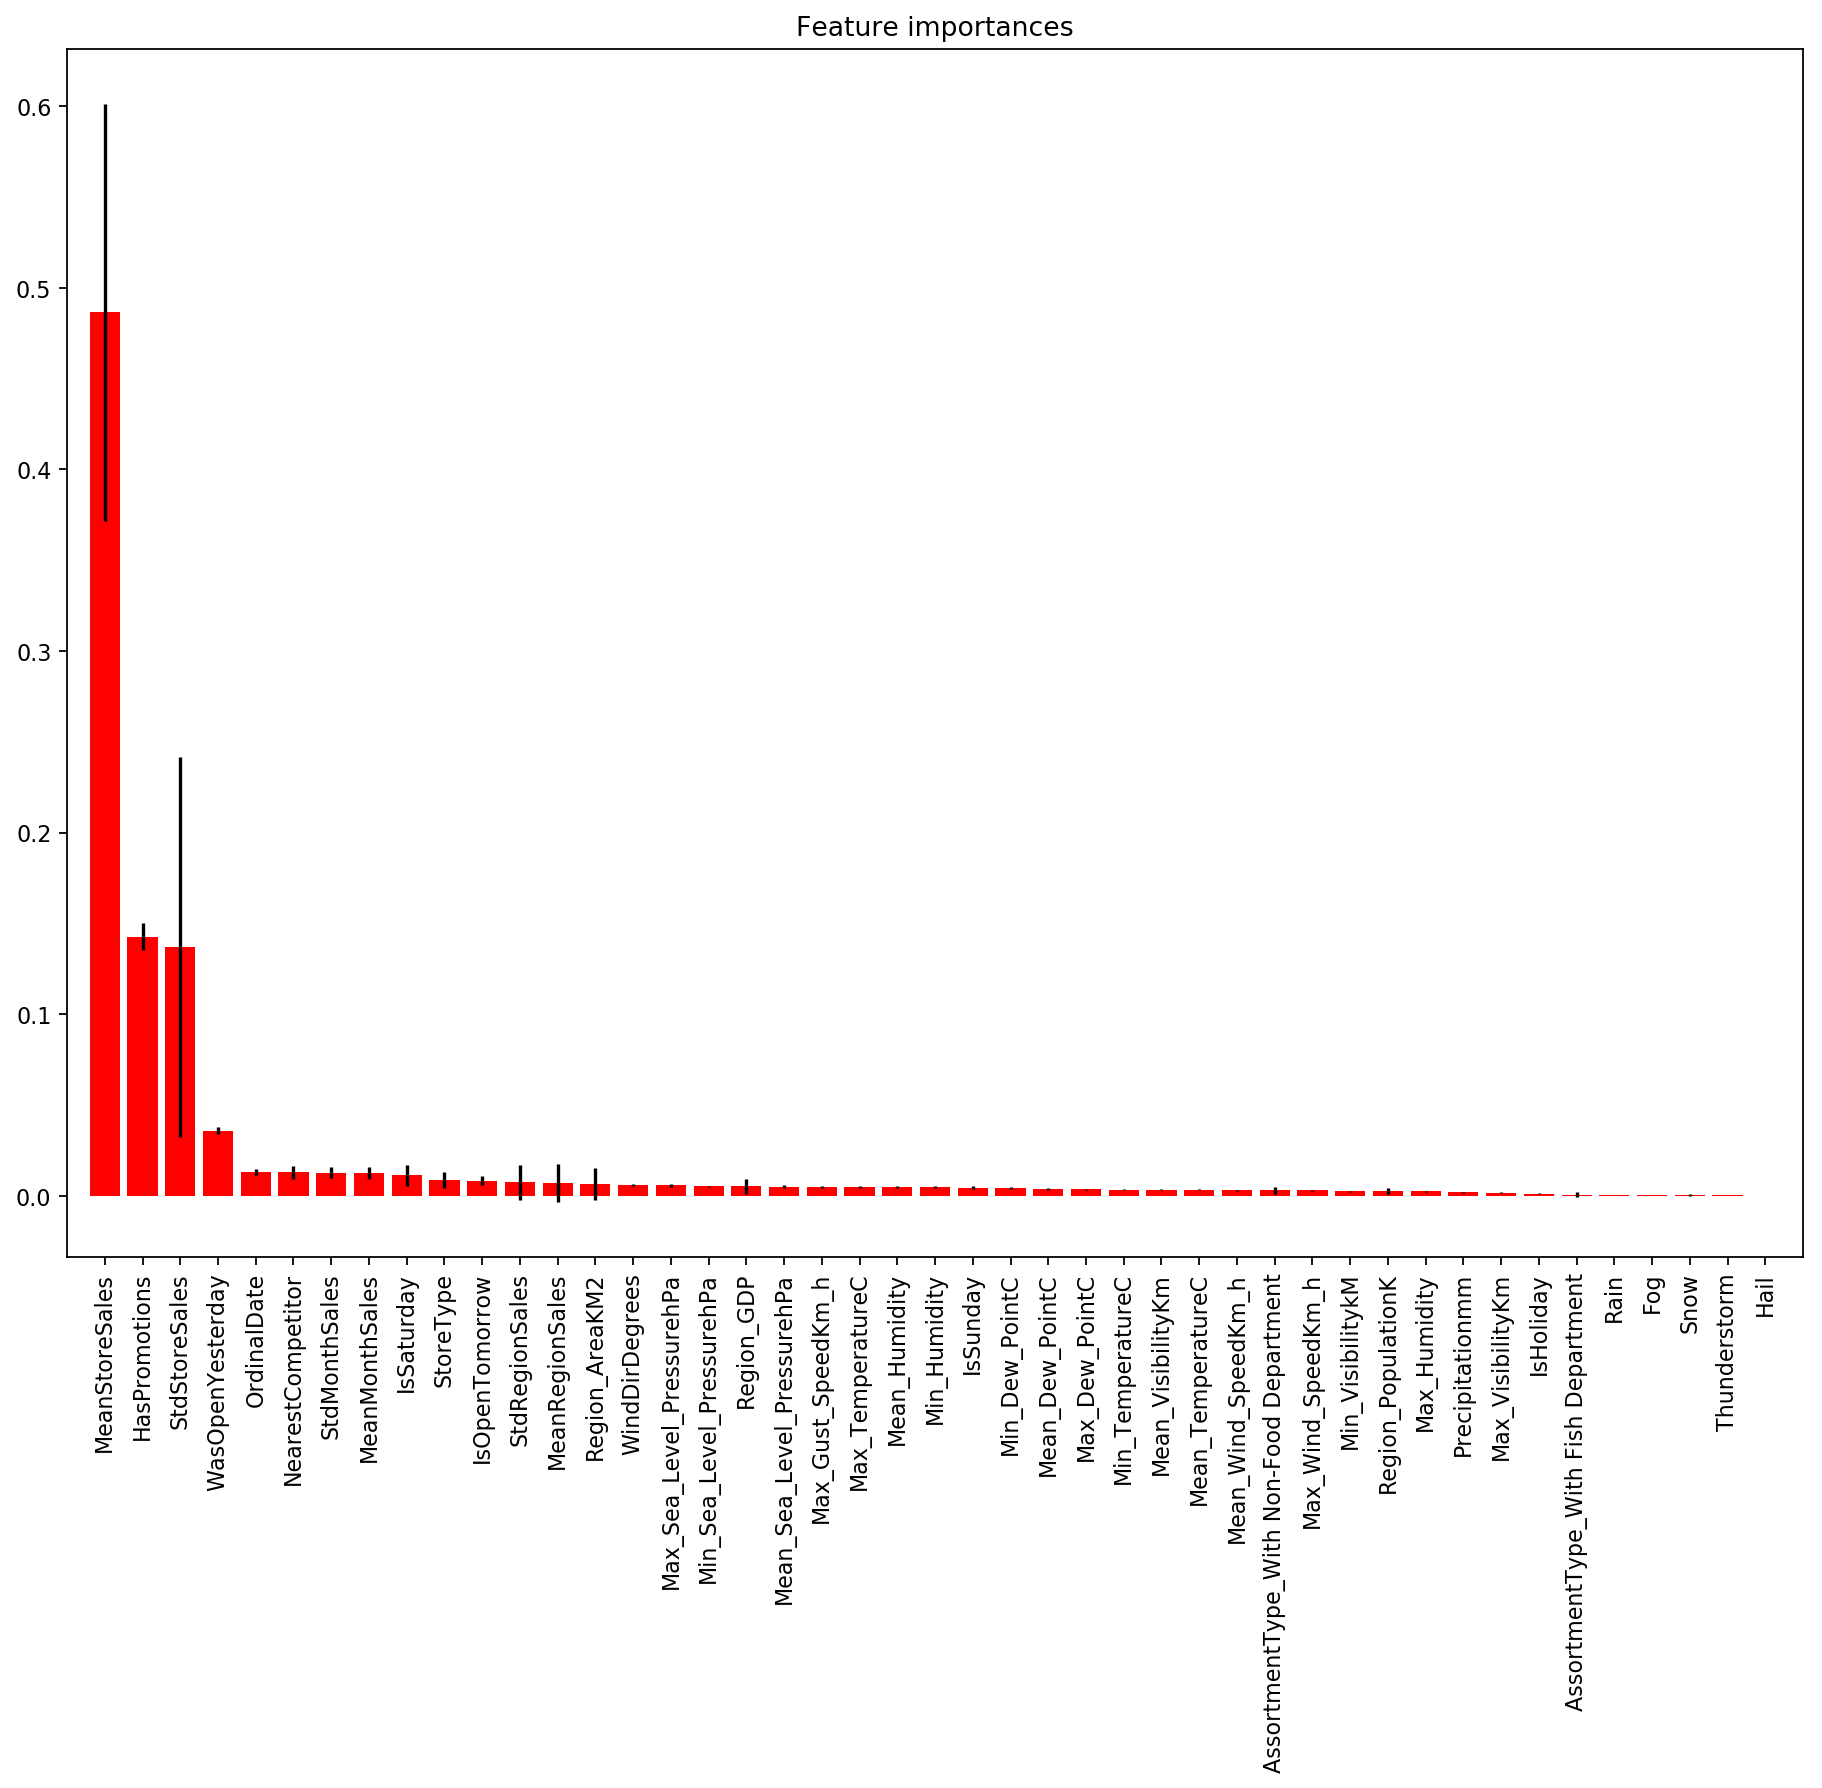

In [10]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], X.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(num=None, figsize=(14, 10), dpi=80, facecolor='w', edgecolor='k')
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices] ,rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

Select some feature to use, discarding others, using a threshold

In [11]:
feature_selection_model = SelectFromModel(forest, threshold=0.007, prefit=True)

In [12]:
X_selected_features_forest = feature_selection_model.transform(X)
X_val1_selected_features_forest = feature_selection_model.transform(X_val1)
X_df_selected_features_forest = feature_selection_model.transform(X_df)
X_selected_features_forest.shape

(365719, 13)

In [13]:
test = pd.read_csv("dataset/processed/val2.csv", index_col=0)
test.OrdinalDate = test.OrdinalDate.map(lambda x: x % 365)
y_val2=test['NumberOfSales']
X_val2=test.drop(['StoreID','Date', 'NumberOfSales', 'Region'], axis=1)

In [14]:
X_val2_selected_features_forest = feature_selection_model.transform(X_val2)

Find the best hyperparameters on the val1

In [15]:
nt=100
best_mae=100000
best_err=100
for na in range(3,6,1) :
    for depth in range(13,18,1) :
        forest = RandomForestRegressor(max_depth=depth, random_state=0, n_estimators=nt, max_features=na, n_jobs=-1)
        forest.fit(X_selected_features_forest, y)

        y_pred = forest.predict(X_val1_selected_features_forest)
        mae = mean_absolute_error(y_val1, y_pred)
        err=errore(y_pred,y_val1,val)

        if(err<best_err):
            best_mae=mae
            best_depth=depth
            best_na=na
            best_err=err

        print(na, depth, mae, err)
print(best_na, best_depth, best_mae, best_err)

3 13 609.6913043173016 0.053959499116267164
3 14 597.2140594494422 0.05303596676010593
3 15 589.4641782368078 0.052755427817964475
3 16 585.280428810217 0.05234387316063971
3 17 581.7712367801488 0.052632309828833455
4 13 603.3706768963552 0.052763904841182006
4 14 596.0112961794055 0.0523954171772635
4 15 589.5350665171679 0.051964238477965566
4 16 584.8282202456626 0.05238998394685731
4 17 588.0299049102091 0.05283786009079826
5 13 605.214049142179 0.052827953692309304
5 14 593.4270159588066 0.05320540822092838
5 15 589.8909494045145 0.05288737295387615
5 16 584.1540884603419 0.052772574389560546
5 17 585.872646491446 0.05270499290972103
4 15 589.5350665171679 0.051964238477965566


calculate the error on val2, training the model on the train set+val1

In [16]:
na=4
depth=15
nt=250
forest = RandomForestRegressor(max_depth=depth, random_state=0, n_estimators=nt, max_features=na, n_jobs=-1)
forest.fit(X_df_selected_features_forest, y_df)

y_pred = forest.predict(X_val2_selected_features_forest)
mae = mean_absolute_error(y_val2, y_pred)

print(mae)

522.2478656168171


In [17]:
errore(y_pred,y_val2,test)

0.04681976497747984

Save the results of val2 on a external file

In [46]:
y_val2=y_val2.reset_index(drop=True)
test=test.reset_index(drop=True)

In [47]:
columns=['Date', 'StoreID', 'RegionID', 'SalesPredicted', 'SalesReal']
index=range(y_val2.shape[0])
result=pd.DataFrame(index=index,columns=columns)
result['Date']=test['Date']
result['StoreID']=test['StoreID']
result['RegionID']=test['Region']
result['SalesPredicted']=y_pred
result['SalesReal']=y_val2

In [48]:
result.head(5)

,Date,StoreID,RegionID,SalesPredicted,SalesReal
0,2018-01-01,1000,7,10215.380190,8540.0
1,2018-01-02,1000,7,6260.330260,10364.0
2,2018-01-03,1000,7,5633.790503,4676.0
3,2018-01-05,1000,7,7124.053507,6267.0
4,2018-01-06,1000,7,6228.749014,5953.0


In [49]:
result.to_csv("results/results_rf.csv")